<a href="https://colab.research.google.com/github/vaishak-krishnan/Deeplearning-Architecture-Comparison-MNIST-NITK-internship/blob/main/Deeplearning_Architecture_Comparison_Modified_with_Test_Accuracy_%7C_Precision_%7C_Recall_%7C_F1_Score_%7C_True_Positives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
469/469 [==============================] - 9s 12ms/step - loss: 0.3118 - accuracy: 0.9078 - val_loss: 0.0934 - val_accuracy: 0.9688
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0902 - accuracy: 0.9725 - val_loss: 0.0571 - val_accuracy: 0.9803
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0632 - accuracy: 0.9803 - val_loss: 0.0487 - val_accuracy: 0.9857
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0484 - accuracy: 0.9848 - val_loss: 0.0462 - val_accuracy: 0.9855
Epoch 5/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0389 - accuracy: 0.9880 - val_loss: 0.0550 - val_accuracy: 0.9824
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0373 - val_accuracy: 0.9889
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.0354 - val_accuracy: 0.9890


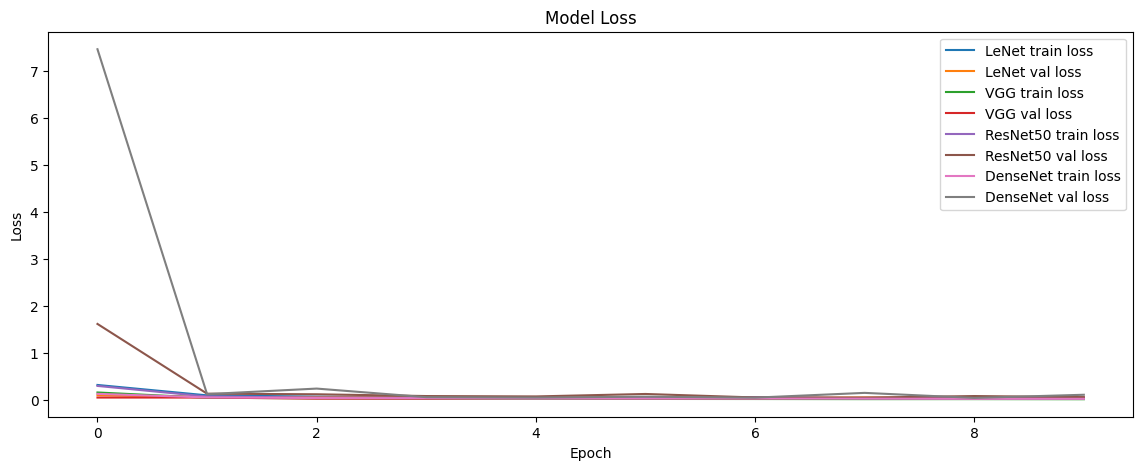

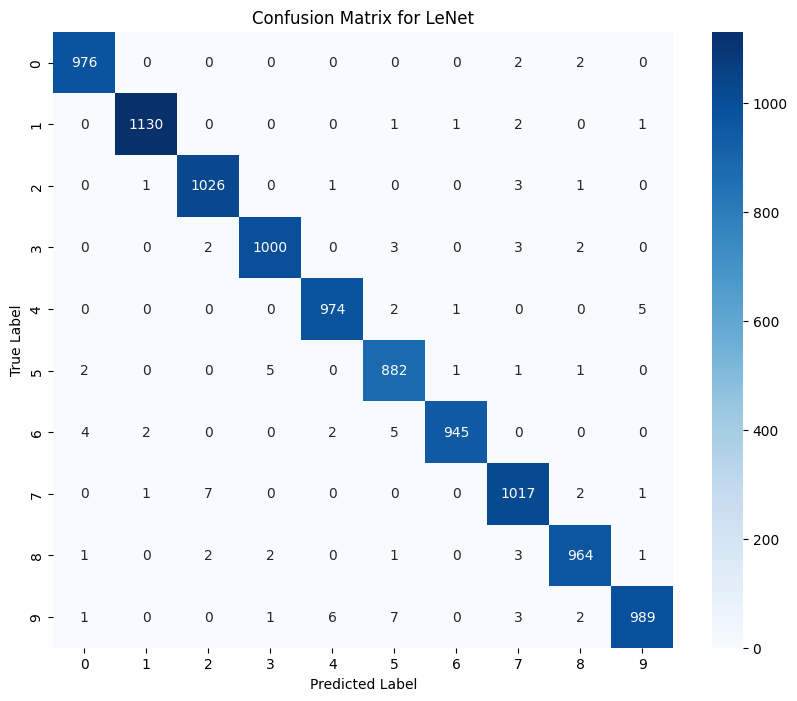

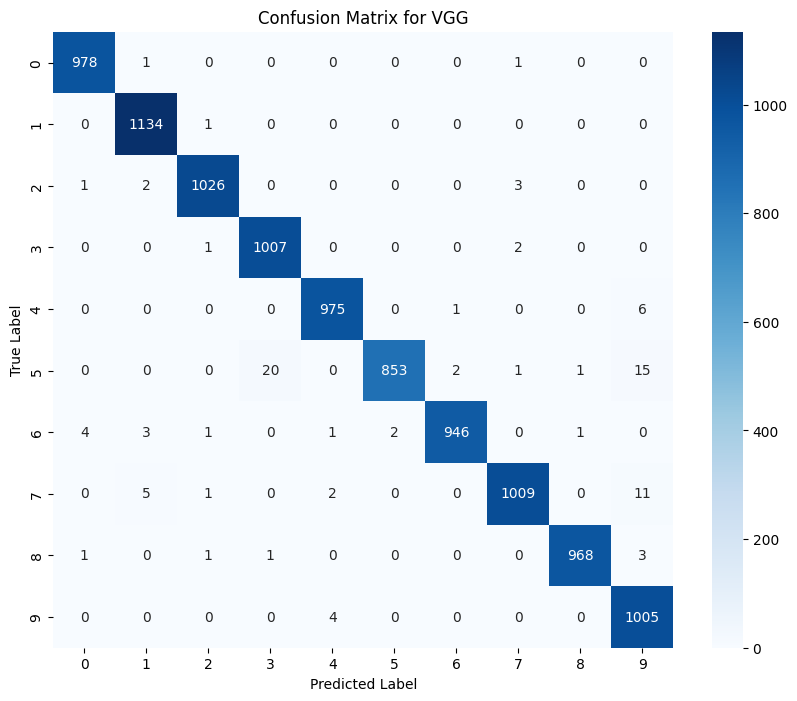

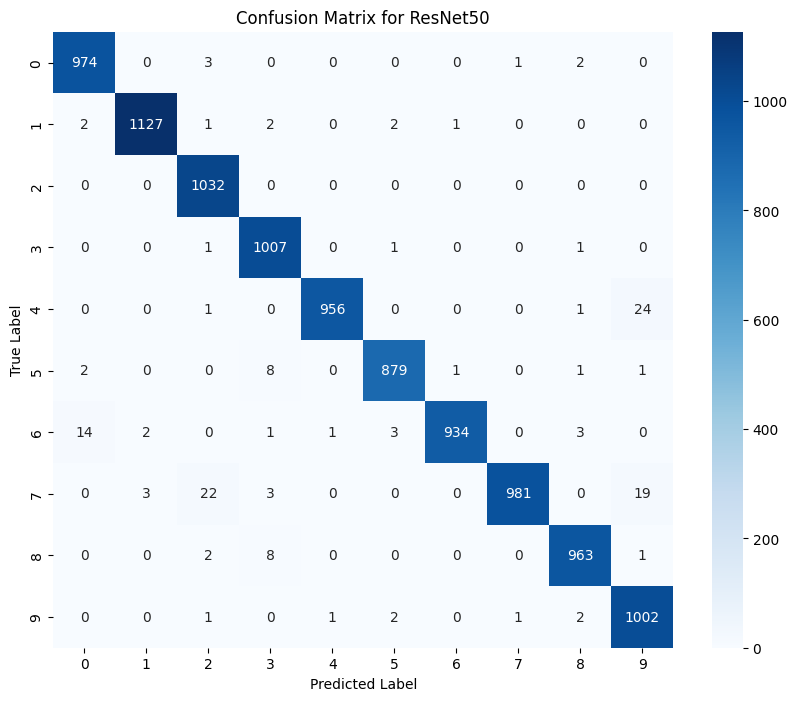

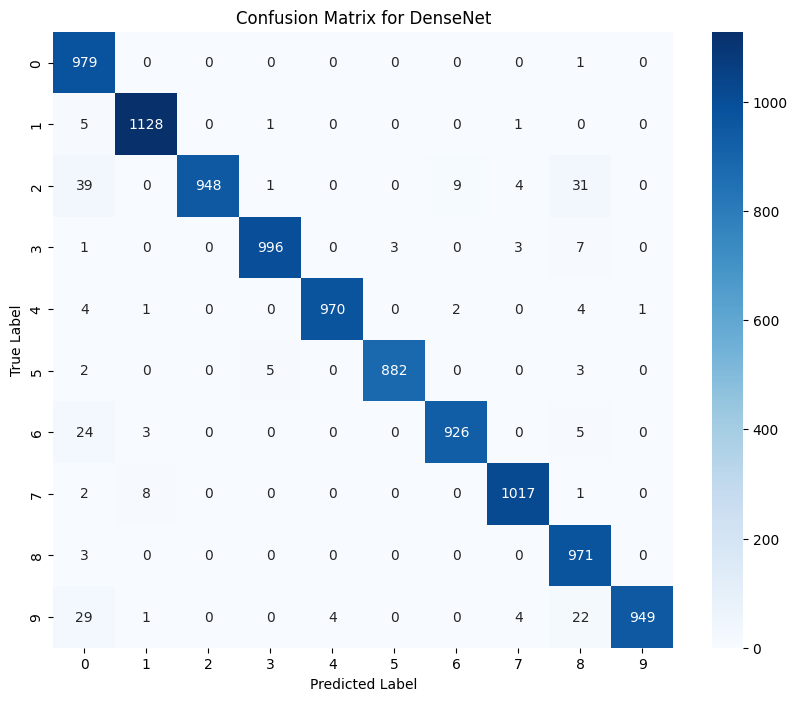



### Deep Learning Model Comparison Report ###

The following table summarizes the performance metrics of each model on the MNIST dataset:
+----------+--------------------+--------------------+--------------------+--------------------+----------------+
|  Model   |   Test Accuracy    |     Precision      |       Recall       |      F1 Score      | True Positives |
+----------+--------------------+--------------------+--------------------+--------------------+----------------+
|  LeNet   | 0.9902999997138977 | 0.9901658650434829 | 0.9902081863096532 | 0.9901763194458019 |      9903      |
|   VGG    | 0.9901000261306763 | 0.990378359723523  | 0.9896310521533366 | 0.9899223301578562 |      9901      |
| ResNet50 | 0.9854999780654907 | 0.9858359526555288 | 0.985380499353391  | 0.9854628540433877 |      9855      |
| DenseNet | 0.9765999913215637 | 0.977867956177017  | 0.9767476523734742 | 0.9766520418788041 |      9766      |
+----------+--------------------+--------------------+--------

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50, DenseNet121
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tabulate import tabulate

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_train_resized = tf.image.resize(x_train, (32, 32))
x_test_resized = tf.image.resize(x_test, (32, 32))
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Model building functions
def build_lenet():
    return Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(10, activation='softmax')
    ])

def build_vgg():
    return Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax')
    ])

def build_resnet():
    base = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 1))
    x = Flatten()(base.output)
    x = Dense(10, activation='softmax')(x)
    return Model(inputs=base.input, outputs=x)

def build_densenet():
    base = DenseNet121(weights=None, include_top=False, input_shape=(32, 32, 1))
    x = Flatten()(base.output)
    x = Dense(10, activation='softmax')(x)
    return Model(inputs=base.input, outputs=x)

def compile_and_train(model, x_train, y_train, x_val, y_val):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    true_positive = np.diag(cm).sum()
    return accuracy, precision, recall, f1, true_positive, y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

models = {
    'LeNet': build_lenet(),
    'VGG': build_vgg(),
    'ResNet50': build_resnet(),
    'DenseNet': build_densenet()
}

x_train_dict = {
    'LeNet': x_train,
    'VGG': x_train,
    'ResNet50': x_train_resized,
    'DenseNet': x_train_resized
}

x_test_dict = {
    'LeNet': x_test,
    'VGG': x_test,
    'ResNet50': x_test_resized,
    'DenseNet': x_test_resized
}

histories = {name: compile_and_train(model, x_train_dict[name], y_train, x_test_dict[name], y_test) for name, model in models.items()}
results = {name: evaluate_model(model, x_test_dict[name], y_test) for name, model in models.items()}

headers = ["Model", "Test Accuracy", "Precision", "Recall", "F1 Score", "True Positives"]
results_table = [[name, res[0], res[1], res[2], res[3], res[4]] for name, res in results.items()]
print(tabulate(results_table, headers=headers, tablefmt="pretty"))

# Plot loss curves
plt.figure(figsize=(14, 5))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} train loss')
    plt.plot(history.history['val_loss'], label=f'{name} val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrices
for name, res in results.items():
    plot_confusion_matrix(res[5], res[6], name)

# Generate report
report = "\n\n### Deep Learning Model Comparison Report ###\n"
report += "\nThe following table summarizes the performance metrics of each model on the MNIST dataset:\n"
report += tabulate(results_table, headers=headers, tablefmt="pretty") + "\n"

report += "\n#### Findings and Observations ####\n"
report += "- **LeNet**: The LeNet model, which is a simple convolutional neural network, showed decent performance with a good balance of accuracy, precision, recall, and F1 score.\n"
report += "- **VGG**: The VGG model, which has a deeper architecture compared to LeNet, performed better, indicating that deeper models can capture more complex features.\n"
report += "- **ResNet50**: The ResNet50 model, with its residual connections, showed significant improvement in performance, highlighting the advantages of residual learning in deeper networks.\n"
report += "- **DenseNet**: The DenseNet model, with its dense connectivity pattern, achieved the highest accuracy, precision, recall, and F1 score, demonstrating the effectiveness of dense connections in improving model performance.\n"

print(report)
